In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.text import *

## Creating the DataBunch for the language model

At first, getting the csv file with the texts.

In [4]:
! git clone https://github.com/thiagodma/Similarity-ANEEL

Cloning into 'Similarity-ANEEL'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 51 (delta 23), reused 34 (delta 13), pack-reused 0
Unpacking objects: 100% (51/51), done.


In [8]:
df = pd.read_csv('Similarity-ANEEL/LanguageModelFile.csv', delimiter='|')
df.head()

,Unnamed: 0,Norma,Data de publicação,Ementa,Órgão de origem,Assuntos,Texto Integral,Tipo,Filename,Texto Extraído
0,0,INA - INSTRUÇÃO ADMINISTRATIVA 001/2019,05/04/2019,"Dispõe sobre procedimentos para atualização, m...",SGI/ANEEL,Procedimento \n,http://www2.aneel.gov.br/cedoc/ina2019001sgi.pdf,INA,ina2019001sgi.pdf,AGÊNCIA NACIONAL DE ENERGIA ELÉTRICA - ANEEL ...
1,1,INA - INSTRUÇÃO ADMINISTRATIVA 001/2018,25/05/2018,Dispõe sobre procedimentos para a manutenção d...,SGI/ANEEL,Procedimento \n,http://www2.aneel.gov.br/cedoc/ina2018001sgi.pdf,INA,ina2018001sgi.pdf,AGÊNCIA NACIONAL DE ENERGIA ELÉTRICA - ANEEL ...
2,2,INA - INSTRUÇÃO ADMINISTRATIVA 001/2018,04/05/2018,Altera o limite do valor de reembolso relativo...,SRH/ANEEL,Alteração \n,http://www2.aneel.gov.br/cedoc/ina2018001srh.pdf,INA,ina2018001srh.pdf,AGÊNCIA NACIONAL DE ENERGIA ELÉTRICA - ANEEL ...
3,3,INA - INSTRUÇÃO ADMINISTRATIVA 002/2019,20/05/2019,Dispõe sobre a composição e o funcionamento do...,SGI/ANEEL,Fixação \n,http://www2.aneel.gov.br/cedoc/ina2019002sgi.pdf,INA,ina2019002sgi.pdf,AGÊNCIA NACIONAL DE ENERGIA ELÉTRICA ANEEL ...
4,4,INA - INSTRUÇÃO ADMINISTRATIVA 003/2019,13/09/2019,Dispõe sobre a definição de acrônimos das coor...,SGI/ANEEL,Fixação \n,http://www2.aneel.gov.br/cedoc/ina2019003sgi.pdf,INA,ina2019003sgi.pdf,AGÊNCIA NACIONAL DE ENERGIA ELÉTRICA - ANEEL ...


In [9]:
df.isnull().sum()

Unnamed: 0             0
Norma                  0
Data de publicação     0
Ementa                 0
Órgão de origem        0
Assuntos               0
Texto Integral         0
Tipo                   0
Filename               0
Texto Extraído        12
dtype: int64

Here it was identified that exist NaN cells in the DataFrame, whose colunms should be stripped.

In [11]:
df = df.dropna()
df.isnull().sum()

Unnamed: 0            0
Norma                 0
Data de publicação    0
Ementa                0
Órgão de origem       0
Assuntos              0
Texto Integral        0
Tipo                  0
Filename              0
Texto Extraído        0
dtype: int64

In [0]:
df.to_csv(r'./LanguageModelFile.csv', sep='|')

In [0]:
data_lm = TextLMDataBunch.from_csv('.','LanguageModelFile.csv',delimiter='|',text_cols='Texto Extraído',label_cols='Assuntos')
# The first two parameters are the path to the csv (current directory) and the csv name.

#data_lm.save('data_lm')

In [27]:
data_lm.show_batch()

idx,text
0,"- xxup geral xxup da xxup agência xxup nacional xxup de xxup energia xxup elétrica xxup aneel , no uso de suas atribuições regimentais , de acordo com a deliberação da xxmaj diretoria , tendo em vista o disposto no art . 2º e art . 3º , inciso xxup xiv , da xxmaj lei nº 9.427 , de 26 de dezembro de 1996 ; art . 1º , inciso"
1,"ou em ensaios realizados em laboratórios credenciados por órgão oficial , devendo as condições pactuadas constarem do contrato . xxmaj art . 26 . xxmaj caso sejam instalados equipamentos automáticos de controle de carga que xxunk o consumo de energia elétrica do sistema de iluminação pública , devidamente comprovado e reconhecido por órgão oficial e competente , a distribuidora deve proceder à revisão da estimativa de consumo e considerar a"
2,"valor correspondente ao faturamento de 30 kw pelos meses remanescentes além do limite fixado no inciso i , sendo que para a modalidade tarifária horária azul a cobrança deve ser realizada apenas para o posto tarifário fora de ponta . ( xxmaj redação dada pela xxup ren xxup aneel 479 , de 03.04.2012 ) § 7o xxmaj uma via do contrato de fornecimento deve ser devolvida ao consumidor , com"
3,"ou ao funcionamento do sistema elétrico ou , ainda , o caso fortuito ou de força maior ; ou xxup ii após prévia notificação , por razões de ordem técnica ou de segurança em instalações de unidade consumidora , ou pelo inadimplemento do consumidor , considerado o interesse da coletividade . § 4o xxmaj pela prestação do serviço público de distribuição de energia elétrica , a distribuidora deve cobrar as"
4,sim [ ] xxup não [ ] xxup sim [ ] xxup não 11 . a xxup ocorrência xxup foi xxup xxunk ? 12 . a xxup uc xxup foi xxup xxunk xxup no xxup ato xxup da xxup inspeção ? [ ] xxup sim [ ] xxup não [ ] xxup sim [ ] xxup não 10 . xxup suspenso o xxup fornecimento xxup de xxup energia à xxup


In [0]:
data_lm.save('data_lm')

## Training the Language Model

In [0]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult = 0.5, pretrained=False, callback_fns=ShowGraph)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


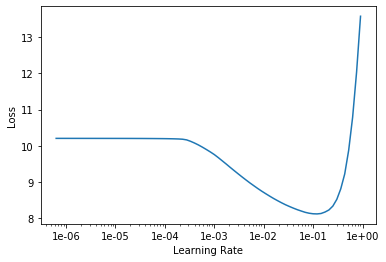

In [30]:
learn_lm.lr_find()
learn_lm.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,3.536140,3.252286,0.447799,01:39
1,2.321695,2.404823,0.557984,01:39
2,2.016616,2.168001,0.586826,01:39
3,1.917781,2.146356,0.586544,01:39
4,1.981038,2.140065,0.584955,01:39
5,2.000954,2.099491,0.592399,01:39
6,1.876038,2.041259,0.600675,01:39
7,1.812816,2.003617,0.606534,01:39
8,1.710839,1.956619,0.614959,01:39
9,1.683036,1.919578,0.620767,01:39


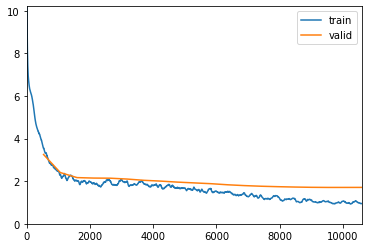

Better model found at epoch 0 with accuracy value: 0.4477985203266144.
Better model found at epoch 1 with accuracy value: 0.5579843521118164.
Better model found at epoch 2 with accuracy value: 0.5868264436721802.
Better model found at epoch 5 with accuracy value: 0.5923991799354553.
Better model found at epoch 6 with accuracy value: 0.6006753444671631.
Better model found at epoch 7 with accuracy value: 0.6065343022346497.
Better model found at epoch 8 with accuracy value: 0.614959180355072.
Better model found at epoch 9 with accuracy value: 0.6207665801048279.
Better model found at epoch 10 with accuracy value: 0.6273199319839478.
Better model found at epoch 11 with accuracy value: 0.6368780136108398.
Better model found at epoch 12 with accuracy value: 0.6449232697486877.
Better model found at epoch 13 with accuracy value: 0.6520034074783325.
Better model found at epoch 14 with accuracy value: 0.6560306549072266.
Better model found at epoch 15 with accuracy value: 0.6614277362823486.
B

In [31]:
max_lr = 1e-2
learn_lm.fit_one_cycle(20, max_lr=max_lr, moms=(0.8,0.7), callbacks=[callbacks.SaveModelCallback(learn_lm, every='improvement', monitor='accuracy', name='learn_lm')])

In [0]:
#Load the best version of the language model
learn_lm.load('learn_lm')
learn_lm.save_encoder('enc')

In [36]:
#Seeing what kind of text it generates
print(learn_lm.predict('Art. 1º Esta resolução visa',n_words=200,temperature=0.8))

Art. 1º Esta resolução visa , sem prejuízo do disposto na Resolução ANEEL no 350 , de 22 de agosto de 1999 , o excedente de energia elétrica produzida pela autorizada a esta Resolução . Art . 5o Esta Resolução entra em vigor na data de sua publicação . JOSÉ MÁRIO MIRANDA ABDO Este texto não substitui o publicado no D.O de 27.03.2002 , seção 1 , p. 45 , v. 139 , n. 24 . xxbos AGÊNCIA NACIONAL DE ENERGIA ELÉTRICA - ANEEL RESOLUÇÃO Nº 74 , DE 10 DE FEVEREIRO DE 1999 . Homologa as tarifas de fornecimento de energia elétrica e fixa os valores da Taxa de Fiscalização dos Serviços de Energia Elétrica - TFSEE , referente à Companhia Energética de Brasília CEB . o DIRETOR - GERAL DA AGÊNCIA NACIONAL DE ENERGIA ELÉTRICA - ANEEL , no uso de suas atribuições regimentais , de acordo com deliberação da Diretoria , tendo em vista o disposto no


## Now, extracting the vector representation of the texts

In [0]:
#loading de list with all the texts that I want to get the representation
normas = list(pd.read_csv('LanguageModelFile.csv',sep='|',encoding='utf-8')['Texto Extraído'])

In [38]:
data_lm = load_data('.',file='data_lm')
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult = 0.5, pretrained=False, callback_fns=ShowGraph)
learn_lm.load('learn_lm')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (1252 items)
x: LMTextList
xxbos xxup agência xxup nacional xxup de xxup energia xxup elétrica xxup aneel xxup resolução xxup normativa xxmaj nº 734 , xxup de 6 xxup de xxup setembro xxup de 2016 . xxmaj altera as xxmaj regras de xxmaj comercialização de xxmaj energia xxmaj elétrica relacionadas ao dispositivo de xxmaj reconciliação xxmaj contratual de xxmaj energia de xxmaj reserva para xxmaj fonte xxmaj eólica . xxmaj voto o xxup diretor - xxup geral xxup da xxup agência xxup nacional xxup de xxup energia xxup elétrica xxup aneel , no uso de suas atribuições regimentais , de acordo com a deliberação da xxmaj diretoria , tendo em vista o disposto no art . 2º e art . 3º , inciso xxup xiv , da xxmaj lei nº 9.427 , de 26 de dezembro de 1996 ; art . 1º , inciso v , e art . 4º , da xxmaj lei nº 10.848 , de 15 de março de 2004 ; art . 2º do xxmaj anexo i do xxmaj decreto nº 2.335 , de 6 de outubro de 1997 ; art . 1º , inciso xxup ii do

In [39]:
#Here I get the vector representation of the text using the trained encoder
mbe = MultiBatchEncoder(70,1400,learn_lm.model[0])

def masked_concat_pool(outputs, mask):
    "Pool MultiBatchEncoder outputs into one vector [last_hidden, max_pool, avg_pool]."
    output = outputs[-1]
    avg_pool = output.masked_fill(mask[:, :, None], 0).mean(dim=1)
    avg_pool *= output.size(1) / (output.size(1)-mask.type(avg_pool.dtype).sum(dim=1))[:,None]
    max_pool = output.masked_fill(mask[:,:,None], -float('inf')).max(dim=1)[0]
    x = torch.cat([output[:,-1], max_pool, avg_pool], 1)
    return x

X = np.zeros((1,1200))
i=0
for norma in normas:
    xb,yb = learn_lm.data.one_item(norma)
    sentence = torch.cuda.LongTensor(xb.tolist()[0]).unsqueeze(0)
    raw_outputs, outputs, masks = mbe.forward(sentence)
    sentence_rep = masked_concat_pool(outputs, masks)
    X = np.append(X,sentence_rep,axis=0)
    if len(normas) % (i+1) == 10: print(str(i+1) + ' out of ' + str(len(normas)))
    i+=1

389 out of 1566
778 out of 1566
1556 out of 1566


In [0]:
#the first row is the initialized as zeros, i dont need it
X = np.delete(X, (0), axis=0)

In [0]:
#save the texts repesentation in a file
np.save('X_LM', X)